# Kepler dataset 

* Goal: Predict koi_disposition using all vaiables except koi_pdispositon   
* Secondary goal: Using 'CANDIDATES' from koi_pdisposition predict which rows are most likely to become 'CONFIRMED' in koi_disposition 

In [60]:
#
# Imports 
#
import pandas as pd
import numpy as np
from sklearn import preprocessing
import keras
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import regularizers
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 

%matplotlib notebook

In [61]:
def fill_median(data):
    for column in data.columns:
        print("Current columns: ", column, data[column].dtypes)
        tmp = data[column].dtypes
        
        if tmp == 'int64' or tmp == 'float64':
            median = data[column].median()
            data[column] = data[column].fillna(median)
            
    return data

def create_3d_plot(data, target, figsize, class_list):
    plt.clf()
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    for c, dispo, a in class_list:
        tmp_df = data[data[target] == dispo]
        xs = tmp_df['X']
        ys = tmp_df['Y']
        zs = tmp_df['Z']
        ax.scatter(xs, ys, zs, s=30, alpha=a, edgecolors='w', c=c)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # ax.view_init(30, 90)
    # plt.show()
    
    # rotate the axes and update
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)

    
def outlier_detector(data, contamination=0.01):
    #print("----------------- ISOLATION  FOREST -----------------------")
    inliers = np.ones((len(data),), dtype=int)
    inliers_df = pd.DataFrame(inliers)
    
    for column in data.columns[2:]:
        
        clf = IsolationForest(random_state=0, n_estimators=300,verbose=0, n_jobs=16, contamination=contamination, max_features=1)
        clf.fit(data[column].values.reshape(-1,1))
        predictions = clf.predict(data[column].values.reshape(-1,1))
        
        predictions_df = pd.DataFrame(predictions, columns=['pred'])
        #print('----', column, '----', '\n', predictions_df['pred'].value_counts())
        inliers_df[predictions_df['pred'] == -1] = -1
        
    return inliers_df

In [62]:
#
# Import dataset 
#
data = pd.read_csv('cumulative.csv')

In [63]:
#
# Data cleaning 
#

drop_columns = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_score', 'koi_teq_err1', 'koi_teq_err2', 'koi_tce_delivname']
data[drop_columns].head()

,rowid,kepid,kepoi_name,kepler_name,koi_score,koi_teq_err1,koi_teq_err2,koi_tce_delivname
0,1,10797460,K00752.01,Kepler-227 b,1.000,NaN,NaN,q1_q17_dr25_tce
1,2,10797460,K00752.02,Kepler-227 c,0.969,NaN,NaN,q1_q17_dr25_tce
2,3,10811496,K00753.01,NaN,0.000,NaN,NaN,q1_q17_dr25_tce
3,4,10848459,K00754.01,NaN,0.000,NaN,NaN,q1_q17_dr25_tce
4,5,10854555,K00755.01,Kepler-664 b,1.000,NaN,NaN,q1_q17_dr25_tce


`rowid` - The data in this column is nothing more than an index.   
`kepid` - Id for solar system.   
`kepoi_name` - Name for solar system and planet number.  
`kepler_name` - Name for exoplanet. NaN represents none expoplanets.   
`koi_score` - NASA prediction score for candidate.   
`koi_teq_err1` - Entire column is NaN.  
`koi_teq_err2` - Entire column is NaN.  

In [64]:
data = data.drop(drop_columns, axis = 1)

In [65]:
rows_nan = data.isna().sum(axis=1)
rows_nan.value_counts()

0     8744
1      263
29     230
6       95
30      91
10      89
26      42
7        8
16       2
dtype: int64

We got 40 features, to reduce noise in the datset we remove samples that are missing more than 10 % of their feature values, which is 4 or more missing feature values. As we can see in the data above there are several samples that are missing a lot of data. If we were to just insert the median in to these missing values we would introduce noise or skew the data.  

In [66]:
rows_nan = rows_nan[rows_nan >= 4]
rows_nan = rows_nan.reset_index()
data = data.drop(index = rows_nan["index"].to_numpy(), axis = 0)

In [67]:
rows_nan = data.isna().sum(axis=1)
rows_nan.value_counts()

0    8744
1     263
dtype: int64

In [68]:
data['koi_disposition'].value_counts()

FALSE POSITIVE    4552
CONFIRMED         2292
CANDIDATE         2163
Name: koi_disposition, dtype: int64

We are more interesting to keep 'CANDIDATES' and 'CONFIRMED' in the columnn `koi_disposition` because they add more value in the modeling process compared to 'FALSE POSITIVE', because it's 50% of the dataset while 'CONFIRMED' is about 25%. 



In [69]:
# Seperate False Positives from Candidates and Confirmed
# This is to run seperate Data Cleaning processes on the sets
data_fp = data[data['koi_disposition'] == 'FALSE POSITIVE']
data_cc = data[data['koi_disposition'] != 'FALSE POSITIVE']
data_fp = data_fp.dropna(axis = 0) # Drop every row that contains atleast one NaN
data_cc = fill_median(data_cc) # Fill each NaN with the median of the column

# Merge the two datasets back together after cleaning
data = pd.concat([data_fp, data_cc], axis = 0)

Current columns:  koi_disposition object
Current columns:  koi_pdisposition object
Current columns:  koi_fpflag_nt int64
Current columns:  koi_fpflag_ss int64
Current columns:  koi_fpflag_co int64
Current columns:  koi_fpflag_ec int64
Current columns:  koi_period float64
Current columns:  koi_period_err1 float64
Current columns:  koi_period_err2 float64
Current columns:  koi_time0bk float64
Current columns:  koi_time0bk_err1 float64
Current columns:  koi_time0bk_err2 float64
Current columns:  koi_impact float64
Current columns:  koi_impact_err1 float64
Current columns:  koi_impact_err2 float64
Current columns:  koi_duration float64
Current columns:  koi_duration_err1 float64
Current columns:  koi_duration_err2 float64
Current columns:  koi_depth float64
Current columns:  koi_depth_err1 float64
Current columns:  koi_depth_err2 float64
Current columns:  koi_prad float64
Current columns:  koi_prad_err1 float64
Current columns:  koi_prad_err2 float64
Current columns:  koi_teq float64
Curre

C:\Users\kevso\Anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
#
# Data exploration 
#

Investigate the state changes from `koi_pdisposition` to `koi_disposition`. 

In [71]:
classes = data['koi_disposition'].unique()
array = np.empty((2,3), dtype=np.int64)
for i, c in enumerate(classes, start=0):
    mask = (data['koi_disposition'] == c) & (data['koi_pdisposition'] == 'FALSE POSITIVE')
    l = len(data['koi_disposition'][mask])
    array[0, i] = l
    
    mask = (data['koi_disposition'] == c) & (data['koi_pdisposition'] == 'CANDIDATE')
    l = len(data['koi_disposition'][mask])
    array[1, i] = l
    
df = pd.DataFrame(array, columns=classes, index=['FALSE POSITIVE', 'CANDIDATE'])
df

,FALSE POSITIVE,CONFIRMED,CANDIDATE
FALSE POSITIVE,4358,44,0
CANDIDATE,0,2248,2163


We notice that a 44 cases went from FALSE POSITIVE to CONFIRMED. We extract those special cases to be able to separate them later in visualization.  

**ToDo** Outlier removal

<IPython.core.display.Javascript object>


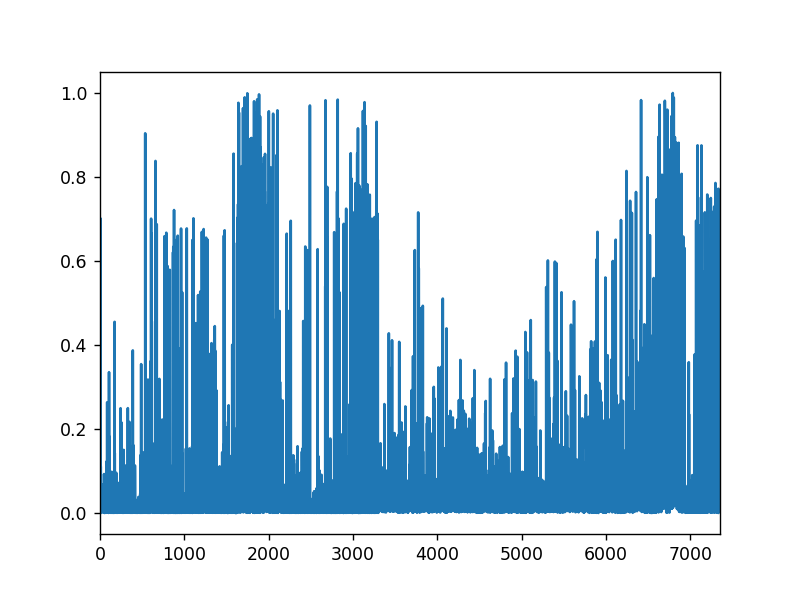

In [72]:
data_norm['koi_period'].plot()

Looking at the values in column `koi_period` we can directly identify that there exists outliers that we need to consider. Thus we remove outliers per feature using the Isolation Forest method. 

In [73]:
inliers = outlier_detector(data[data.columns[2:]], contamination=0.01)
inliers[0].value_counts()

 1    7353
-1    1460
Name: 0, dtype: int64

We find ~1400 

In [74]:
data.reset_index(drop=True, inplace=True)
data.drop(data[inliers[0] == -1].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [75]:
data['koi_disposition'].value_counts()

FALSE POSITIVE    3303
CONFIRMED         2180
CANDIDATE         1870
Name: koi_disposition, dtype: int64

We notice that its mostly FALSE POSITIVE and some CANDIDATES that got removed, e.g. had outliers. 

We standardize data then normalize, making it easier to process for visualization and modeling.

In [76]:
#
# Data preprocessing 
#
standardization = preprocessing.StandardScaler()
standardized_data = standardization.fit_transform(data[data.columns[2:]]) 

normalization = preprocessing.MinMaxScaler()
normalized_data = normalization.fit_transform(standardized_data)

columns = data.columns[2:] 
data_split_x = pd.DataFrame(data = normalized_data, columns = columns)
data_split_y = data[data.columns[0:2]]

data_norm = pd.concat([data_split_y, data_split_x], axis=1)
data_norm.head()

,koi_disposition,koi_pdisposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.035576,0.000466,0.999534,0.170095,...,0.529412,0.788609,0.054208,0.526611,0.056938,0.100829,0.980759,0.797435,0.769203,0.784639
1,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.002609,0.000008,0.999992,0.153057,...,0.534759,0.796254,0.067047,0.549020,0.050443,0.086096,0.983826,0.218897,0.779917,0.807081
2,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,1.0,0.0,0.012819,0.000664,0.999336,0.036072,...,0.668449,0.575306,0.251070,0.745098,0.148882,0.141805,0.867819,0.891227,0.344955,0.397686
3,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.034677,0.000645,0.999355,0.159748,...,0.596257,0.806575,0.094151,0.885154,0.041080,0.026703,0.984384,0.406709,0.733830,0.791748
4,FALSE POSITIVE,FALSE POSITIVE,0.0,1.0,0.0,0.0,0.034345,0.000034,0.999966,0.196845,...,0.465241,0.770260,0.065621,0.436975,0.063602,0.135359,0.975739,0.737400,0.737733,0.771397


**ToDo** Check correlation between features in dataset

PCA visualization

<IPython.core.display.Javascript object>


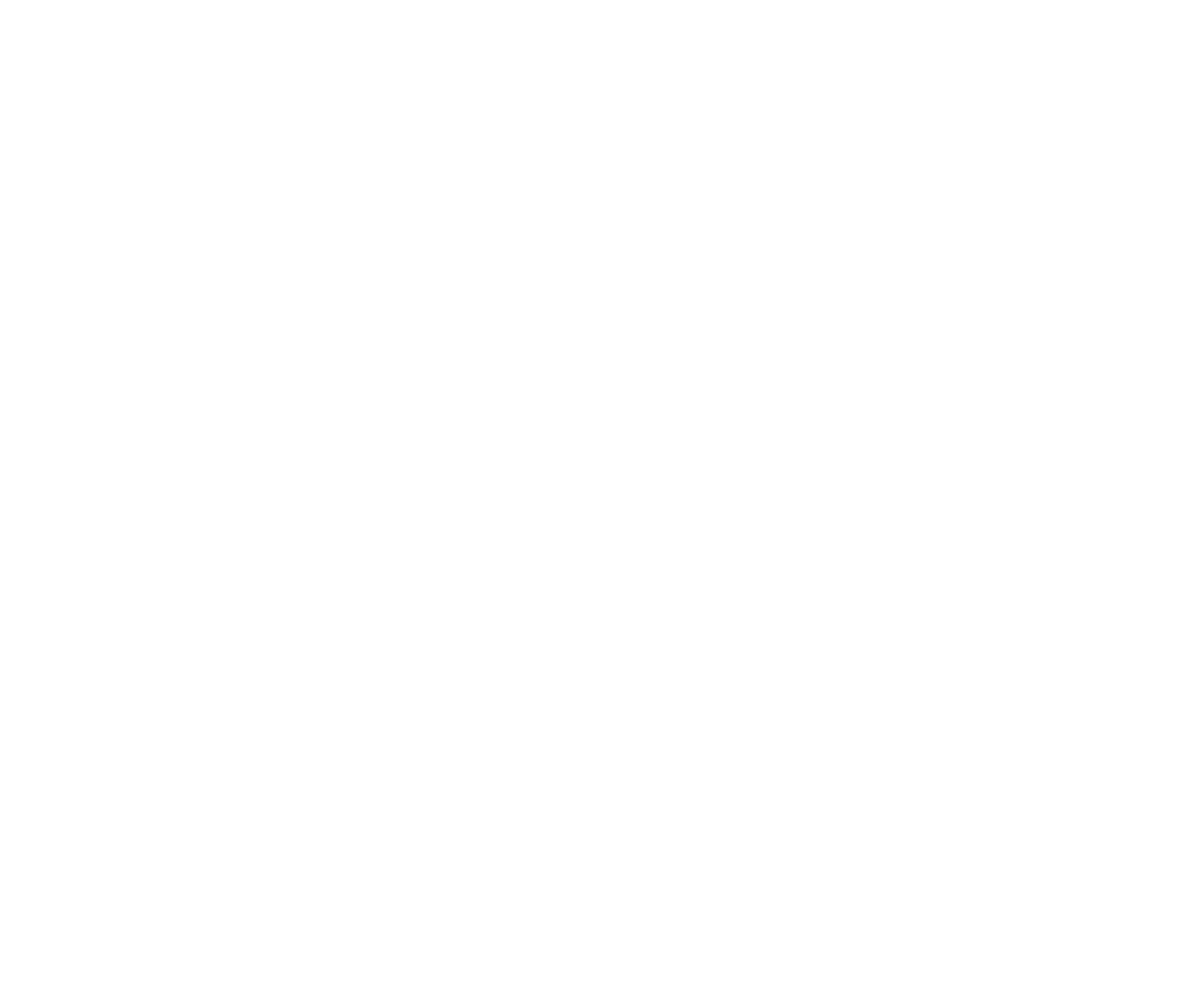

In [77]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components = 2)
data_pca = pd.DataFrame(pca.fit_transform(data_split_x), columns = ['X', 'Y'])
data_pca = pd.concat([data_split_y, data_pca], axis = 1)
sns.lmplot(x='X', y='Y', hue = 'koi_disposition', data=data_pca, scatter_kws={'alpha':1, 's':4}, height=8)

We notice a cluster for CONFIRMED and CANDIDATE, and several clusters for FALSE POSITIVES. We have several samples of CONFIRMED and CANDIDATES scattered outside the green cluster even though we cleaned our dataset from outliers. 

An interesting subproblem would be to investigate what is the difference between the FALSE POSITIVE clusters, maybe these could be different types of stellar objects. 

\*The orange CONFIRMED markers are rendered behind the green CANCDIDATE markers. 

<IPython.core.display.Javascript object>


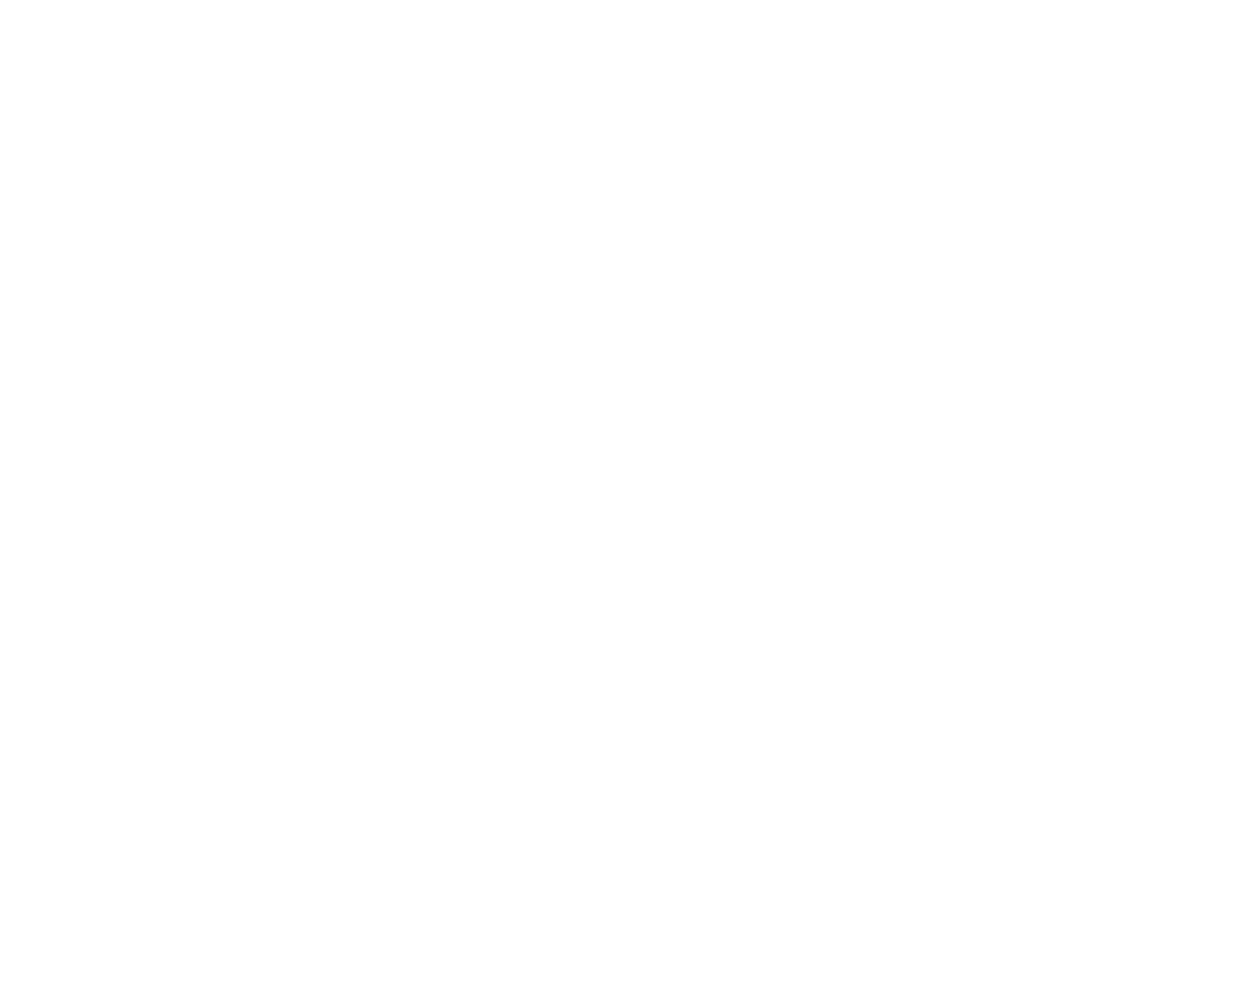

In [96]:
pca = PCA(n_components = 3)
data_pca_3 = pd.DataFrame(pca.fit_transform(data_split_x), columns = ['X', 'Y', 'Z'])
data_pca_3 = pd.concat([data_split_y, data_pca_3], axis = 1)

classes = [('b', 'FALSE POSITIVE', 0.2), ('r', 'CONFIRMED', 0.8), ('g', 'CANDIDATE', 0.8), ('purple', 'FP_CONFIRMED', 1)]
create_3d_plot(data_pca_3,'koi_disposition',(10,8),classes)

In [79]:
lda = LinearDiscriminantAnalysis(n_components = 2)
data_split_lda = data_split_y.replace({'FALSE POSITIVE': 0, 'CANDIDATE': 1, 'CONFIRMED': 2, 'FP_CONFIRMED': 3})

data_lda = pd.DataFrame(lda.fit_transform(data_split_x, data_split_lda['koi_disposition']), columns = ['X', 'Y'])
data_lda = pd.concat([data_split_y, data_lda], axis = 1)

sns.lmplot(x='X', y='Y', hue = 'koi_disposition', data=data_lda, scatter_kws={'alpha':0.3}, height=10)

ValueError: Unknown label type: (array([0, 0, 0, ..., 1, 1, 1], dtype=object),)

In [95]:
#
# Modeling
#
data_norm

############
# Random forest on dataset: data, data_norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
model_dataset = data_norm[data_norm['koi_disposition'] != 'CANDIDATE']
model_dataset = model_dataset[model_dataset['koi_disposition'] != 'FP_CONFIRMED']
#rfc_dataset = rfc_dataset.drop(index=range(0, 2000), axis=0)
X = model_dataset[model_dataset.columns[2:]]
y = model_dataset['koi_disposition']

#Train-Test split
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25, random_state = 0)

from sklearn.metrics import f1_score
models = [RandomForestClassifier(), SVC()]
for model in models:
    model.fit(X_train, y_train)
    result = model.predict(X_test)
    print(model, f1_score(y_test, result, average='micro'))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 0.9941648431801605
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 0.9934354485776805


We visualize the results of the predictions using our PCA projection to 3D. From the visualization we can better decide which model is better rather than relying fully on the accuracy score.  
  
The first visualization will be using RandomForest with default parameters and the second visualization will be with Support Vector Classifier which also uses default parameters.

FALSE POSITIVE    3855
CONFIRMED         3498
dtype: int64


<IPython.core.display.Javascript object>


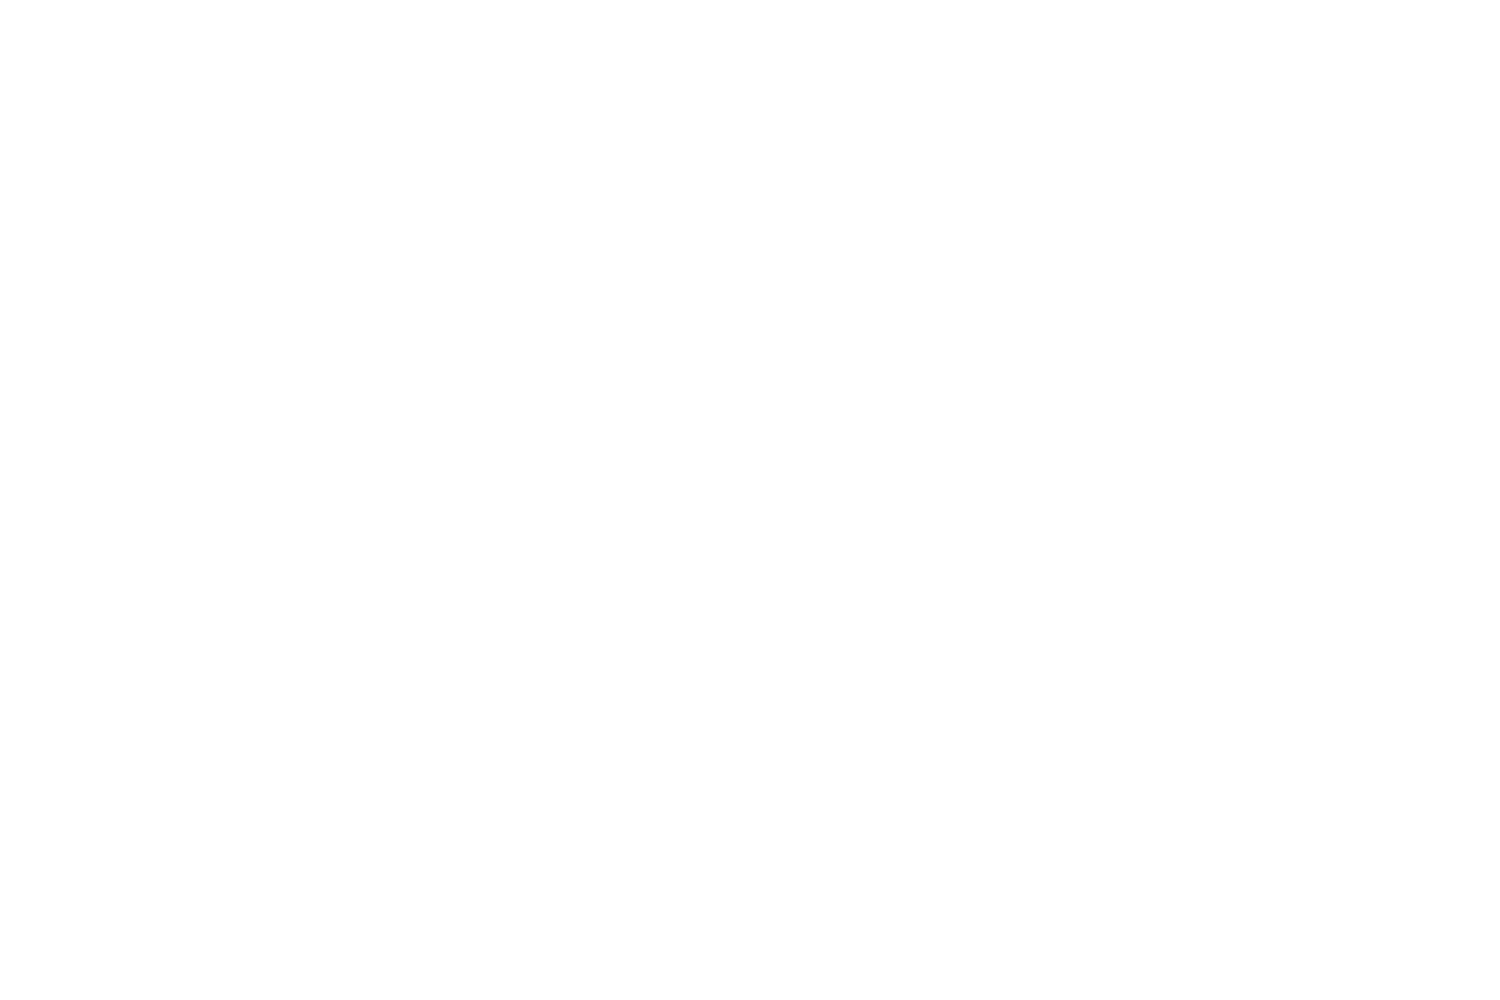

In [97]:
candidate_data = data_norm

res = models[0].predict(candidate_data[candidate_data.columns[2:]])
print(pd.Series(res).value_counts())

rfc_res_series = pd.Series(res,name="Predicted")
rfc_pred_data = data_pca_3
rfc_pred_data = rfc_pred_data.reset_index(drop=True)
rfc_pred_data["Predicted"] = rfc_res_series
classes = [('b', 'FALSE POSITIVE', 0.3), ('r', 'CONFIRMED', 0.6)]
create_3d_plot(rfc_pred_data,'Predicted',(12,8),classes)

The RandomForest model seems to perform poorly when it comes to predicting data from outside its training set. As we can see in the visualization, it introduces several 'False Positives' from new data into a cluster that was 100% 'Confirmed' in its training set. 
  
One explaination for this behavior can be that the model fit very well to its known training set and that the test set it used was very similar which caused high f1 score, but it "boxed in" its boundary too tight to the known data points. A good way of visualizing this is with a 2D example for RandomForest.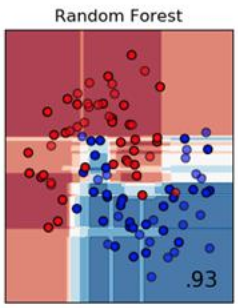
  
The reason for such behavior could be because the dataset contains almost only continuous features and very few categorical features, where RandomForest often performs best on categorical features due how the tree structure is split and built.


CONFIRMED         3977
FALSE POSITIVE    3376
dtype: int64


<IPython.core.display.Javascript object>


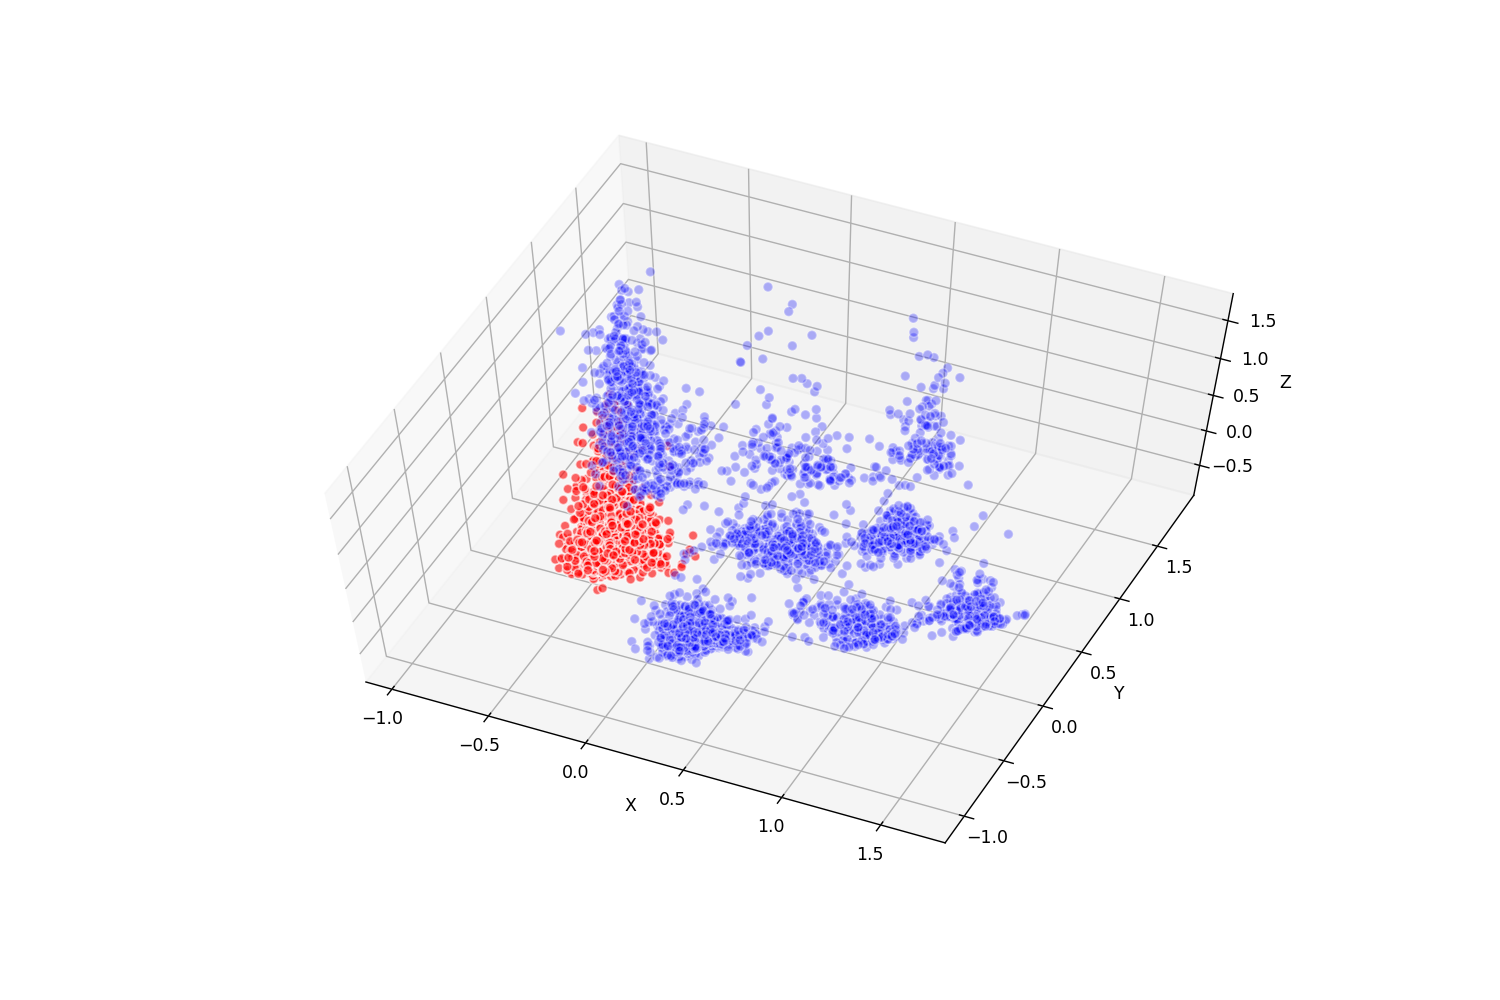

In [98]:
candidate_data = data_norm

res = models[1].predict(candidate_data[candidate_data.columns[2:]])
print(pd.Series(res).value_counts())

rfc_res_series = pd.Series(res,name="Predicted")
rfc_pred_data = data_pca_3
rfc_pred_data = rfc_pred_data.reset_index(drop=True)
rfc_pred_data["Predicted"] = rfc_res_series
classes = [('b', 'FALSE POSITIVE', 0.3), ('r', 'CONFIRMED', 0.6)]
create_3d_plot(rfc_pred_data,'Predicted',(12,8),classes)

In [58]:
#
# Evaluation 
#